In [195]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import scipy.stats as ss
from pandas_datareader import DataReader
from datetime import datetime

# Make plots larger
plt.rcParams['figure.figsize'] = (15, 9)

In [196]:
facebook = DataReader('FB',  'yahoo', datetime(2016,4,1), datetime(2019,9,1));
facebook.reset_index(inplace=True,drop=False)
facebook.set_index('Date')
facebook.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-04-01,116.169998,113.349998,113.750000,116.059998,24760500,116.059998
1,2016-04-04,114.550003,111.610001,114.070000,112.550003,48487900,112.550003
2,2016-04-05,113.320000,111.900002,112.110001,112.220001,22962400,112.220001
3,2016-04-06,113.809998,112.419998,112.470001,113.709999,20814600,113.709999
4,2016-04-07,114.889999,113.070000,113.790001,113.639999,20714500,113.639999


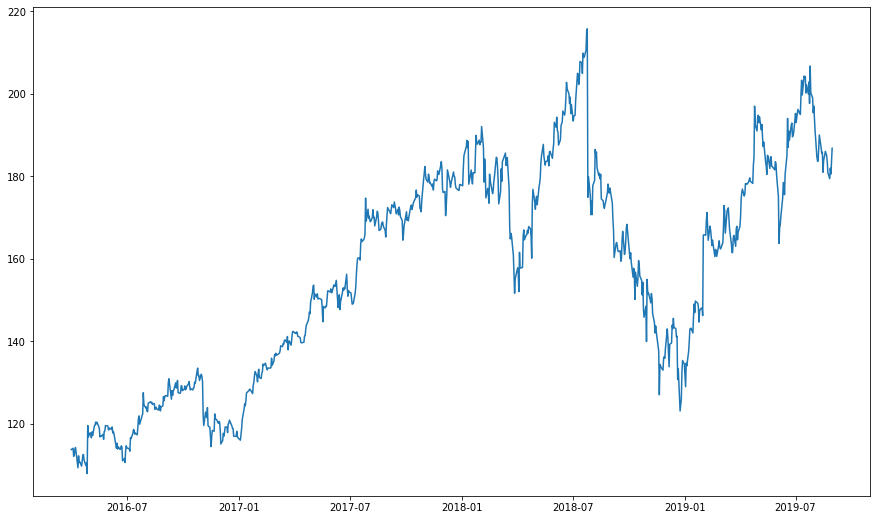

In [197]:
# Plot of Open vs date
plt.plot(facebook['Date'], facebook['Open'])

plt.show()

In [198]:
openmean= (facebook['Open']+ facebook['Close'])/2
#print(openmean)

In [199]:
Y=openmean
print(openmean.var())

691.2366655062507


### KALMAN FILTER

In [200]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def Kalman_Filter(Y):
     S = Y.shape[0]
     S = S + 1
     Z = param0[0]
     T = param0[1]
     H = param0[2]
     Q = param0[3]
     u_predict = np.zeros(S)
     u_update = np.zeros(S)
     P_predict = np.zeros(S)
     P_update = np.zeros(S)
     v = np.zeros(S)
     F = np.zeros(S)
     KF_Dens = np.zeros(S)
     for s in range(1,S):
      if s == 1: 
        P_update[s] = 1000
        P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
      else: 
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]=Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]; 
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
        KF_Dens[s] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]     
        Likelihood = np.sum(KF_Dens[1:-1])  
        return Likelihood


def Kalman_Smoother(params, Y):
 S = Y.shape[0]
 S = S + 1
 "Initialize Params:"
 Z = params[0]
 T = params[1]
 H = params[2]
 Q = params[3]
 
 "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 for s in range(1,S):
   if s == 1: 
    P_update[s] = 1000
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
   else: 
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
    v[s]=Y[s-1]-Z*u_predict[s-1]   
    u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
    u_predict[s] = T*u_update[s]; 
    P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    u_smooth = np.zeros(S)
    P_smooth = np.zeros(S)
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]    
 for  t in range(S-1,0,-1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[t])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
 u_smooth = u_smooth[0:-1]
 return u_smooth

Optimization terminated successfully.
         Current function value: 6.602700
         Iterations: 0
         Function evaluations: 6
         Gradient evaluations: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: OptimizeWarning: Unknown solver options: xtol
  after removing the cwd from sys.path.


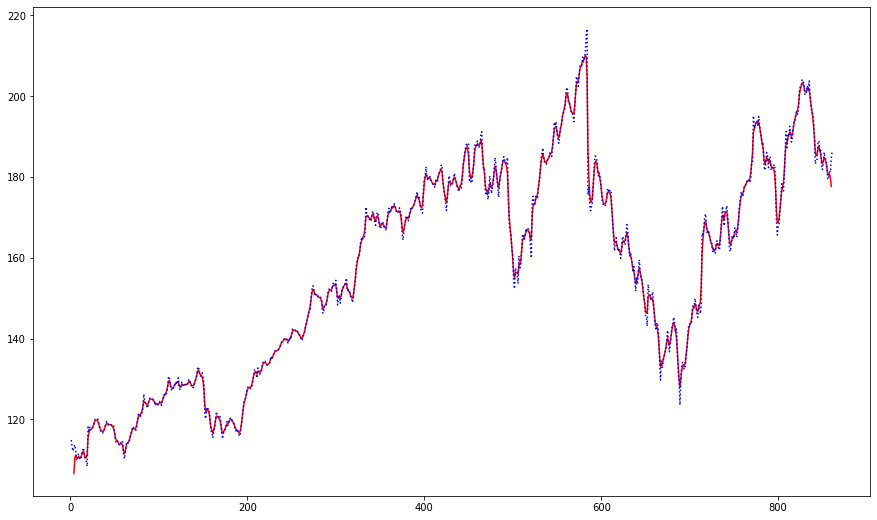

In [204]:
T = 861
Y = openmean
param0 = np.array([0.5, 0.5, openmean.var()*100, 100*openmean.var()])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
Y_update = Kalman_Smoother(param_star.x, Y)
timevec = np.linspace(1,T,T)
plt.plot(timevec[3:-1], Y_update[3:-1],'r',timevec, Y,'b:')

In [205]:
def rmseCalc(Y,Y_hat):
    rmse = np.sqrt(np.mean((Y_update-Y)**2))
    print(rmse)

In [206]:
rmseCalc(Y,Y_update)

4.400720734460765


### GARCH

In [207]:
T = 861;
mu = openmean.mean();
sig  = openmean.var();
Y =openmean

In [208]:
def GARCH(Y):
    mu = param0[0]
    omega = np.exp(param0[1])
    alpha = (1-np.exp(-param0[2])) / (1+np.exp(-param0[2]))
    beta = param0[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T)
    sigma2 = np.zeros(T)
    F = np.zeros(T)
    v = np.zeros(T)
    
    for t in range(1,T):
        sigma2[t] = omega+alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1);
        v[t] = sigma2[t];
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+(1/2)*(F[t]/v[t])
    
    Likelihood = np.sum(GARCH_Dens[1:-1])
    return Likelihood

In [209]:
def GARCH_PROD(params, Y0, T):
    mu = params[0]
    omega = np.exp(params[1])
    alpha = (1-np.exp(-params[2])) / (1+np.exp(-params[2]))
    beta = params[3]
    Y = np.zeros(T)
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = omega/(1-alpha)
    for t in range (1,T):
        sigma2[t] = omega+alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
        Y[t] = mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1);
    return Y  

In [210]:
param_star = minimize(GARCH, param0, method = 'BFGS',options = {'xtol':1e-8,'disp':True})
#param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol':1e-8, 'disp': True})

         Current function value: 7.166589
         Iterations: 2
         Function evaluations: 144
         Gradient evaluations: 22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: OptimizeWarning: Unknown solver options: xtol
  """Entry point for launching an IPython kernel.


         Current function value: 0.562777
         Iterations: 0
         Function evaluations: 162
         Gradient evaluations: 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: OptimizeWarning: Unknown solver options: xtol
  


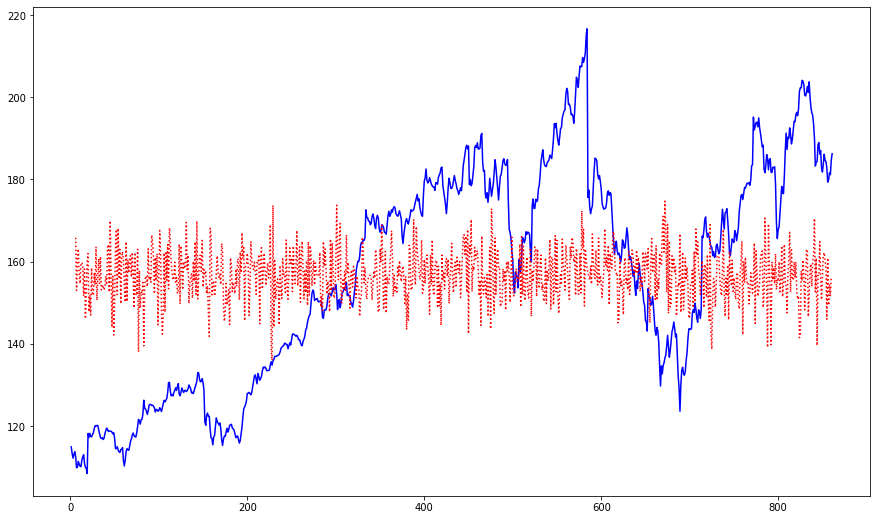

In [211]:
param0 = np.array([mu,2.5,0.3,0.5])
param_star = minimize(GARCH, param0, method = 'BFGS',options = {'xtol':1e-8,'disp':True})
Y_GARCH = GARCH_PROD(param_star.x,Y[0],T)
#Y_GARCH = GARCH_PROD(param_star.x,Y[0],T)
timevec = np.linspace(1,T,T)
plt.plot(timevec, Y ,'b', timevec[5:-1], Y_GARCH[5:-1],'r:')

In [212]:
rmse = np.sqrt(np.mean((Y_GARCH-Y)**2))
print(rmse)

26.812712148714063


### 2 weeks data fitting for Garch and Garch-T

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: OptimizeWarning: Unknown solver options: xtol
/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: OptimizeWarning: Unknown solver options: xtol
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: OptimizeWarning: Unknown solver options: xtol
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: OptimizeWarning: Unknown solver options: xtol


Divide-by-zero encountered: rhok assumed large
         Current function value: 0.676456
         Iterations: 3
         Function evaluations: 179
         Gradient evaluations: 28
         Current function value: 0.210595
         Iterations: 0
         Function evaluations: 150
         Gradient evaluations: 23
6.67327518907264
         Current function value: 0.126254
         Iterations: 4
         Function evaluations: 219
         Gradient evaluations: 33
         Current function value: 0.188265
         Iterations: 4
         Function evaluations: 167
         Gradient evaluations: 26
5.839951719099101


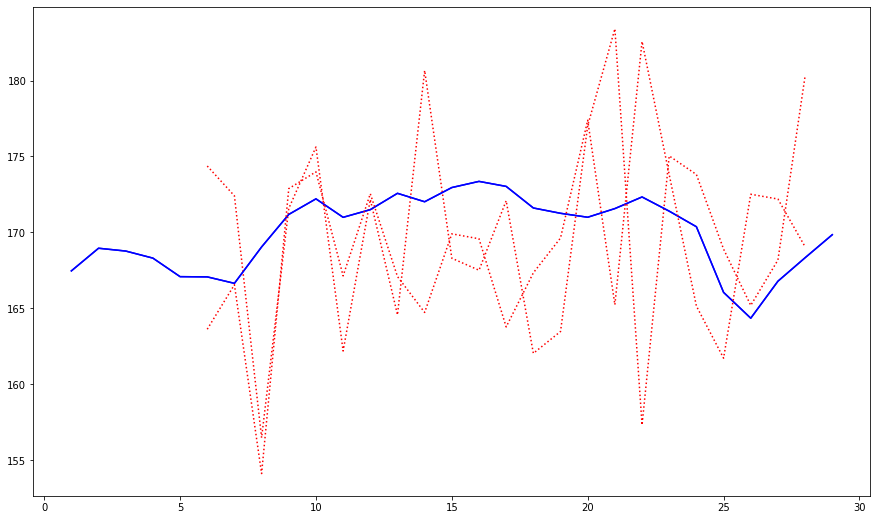

In [213]:


fb=facebook[350:379]
fb.head()
fb.shape

openmean1= (fb['Open']+ fb['Close'])/2
#openmean

def GARCH(Y):
    mu = param0[0]
    omega = np.exp(param0[1])
    alpha = (1-np.exp(-param0[2])) / (1+np.exp(-param0[2]))
    beta = param0[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T)
    sigma2 = np.zeros(T)
    F = np.zeros(T)
    v = np.zeros(T)
    
    for t in range(1,T):
        sigma2[t] = omega+alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1);
        v[t] = sigma2[t];
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+(1/2)*(F[t]/v[t])
    
    Likelihood = np.sum(GARCH_Dens[1:-1])
    return Likelihood

def GARCH_PROD(params, Y0, T):
    mu = params[0]
    omega = np.exp(params[1])
    alpha = (1-np.exp(-params[2])) / (1+np.exp(-params[2]))
    beta = params[3]
    Y = np.zeros(T)
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = omega/(1-alpha)
    for t in range (1,T):
        sigma2[t] = omega+alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
        Y[t] = mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1);
    return Y  

param_star = minimize(GARCH, param0, method = 'BFGS',options = {'xtol':1e-8,'disp':True})

T = 29;
mu = openmean1.mean();
sig  = openmean1.var();
Y=openmean1
param0 = np.array([mu,2.5,0.3,0.5])
param_star = minimize(GARCH, param0, method = 'BFGS',options = {'xtol':1e-8,'disp':True})
Y_GARCH = GARCH_PROD(param_star.x,Y[350],T)
#Y_GARCH = GARCH_PROD(param_star.x,Y[0],T)
timevec = np.linspace(1,T,T)
plt.plot(timevec, Y ,'b', timevec[5:-1], Y_GARCH[5:-1],'r:')

rmse = np.sqrt(np.mean((Y_GARCH-Y)**2))
print(rmse)## 2 week data fitting for Garch and Garch-T

fb=facebook[350:379]
fb.head()
fb.shape

openmean1= (fb['Open']+ fb['Close'])/2
#openmean

def GARCH(Y):
    mu = param0[0]
    omega = np.exp(param0[1])
    alpha = (1-np.exp(-param0[2])) / (1+np.exp(-param0[2]))
    beta = param0[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T)
    sigma2 = np.zeros(T)
    F = np.zeros(T)
    v = np.zeros(T)
    
    for t in range(1,T):
        sigma2[t] = omega+alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1);
        v[t] = sigma2[t];
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+(1/2)*(F[t]/v[t])
    
    Likelihood = np.sum(GARCH_Dens[1:-1])
    return Likelihood

def GARCH_PROD(params, Y0, T):
    mu = params[0]
    omega = np.exp(params[1])
    alpha = (1-np.exp(-params[2])) / (1+np.exp(-params[2]))
    beta = params[3]
    Y = np.zeros(T)
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = omega/(1-alpha)
    for t in range (1,T):
        sigma2[t] = omega+alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
        Y[t] = mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1);
    return Y  

param_star = minimize(GARCH, param0, method = 'BFGS',options = {'xtol':1e-8,'disp':True})

T = 29;
mu = openmean1.mean();
sig  = openmean1.var();
Y=openmean1
param0 = np.array([mu,2.5,0.3,0.5])
param_star = minimize(GARCH, param0, method = 'BFGS',options = {'xtol':1e-8,'disp':True})
Y_GARCH = GARCH_PROD(param_star.x,Y[350],T)
#Y_GARCH = GARCH_PROD(param_star.x,Y[0],T)
timevec = np.linspace(1,T,T)
plt.plot(timevec, Y ,'b', timevec[5:-1], Y_GARCH[5:-1],'r:')

rmse = np.sqrt(np.mean((Y_GARCH-Y)**2))
print(rmse)

In [214]:
df = facebook[['Open']]

df.reset_index(level=0, inplace=True)

df.columns=['ds','y']

### Simple Moving Average

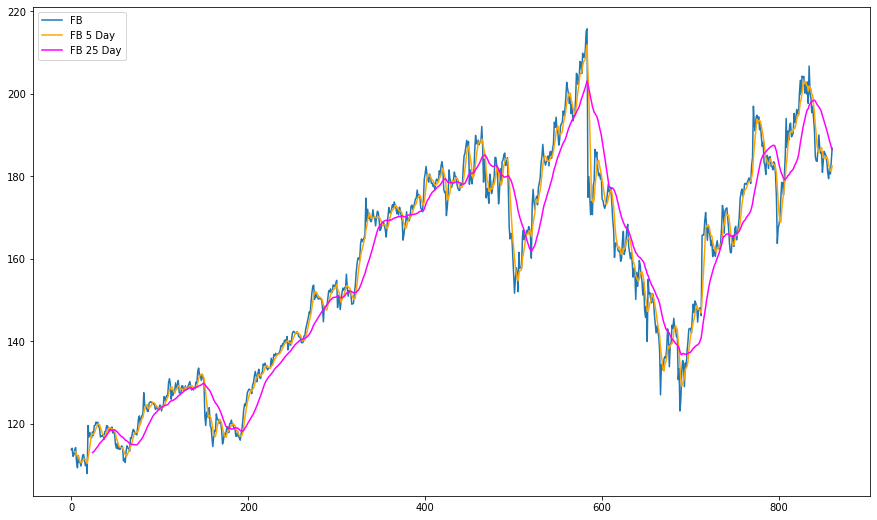

In [215]:
rolAvg = df.y.rolling(window=5).mean()

rolAvg2 = df.y.rolling(window=25).mean()

plt.plot(df.ds, df.y, label='FB')

plt.plot(df.ds, rolAvg, label='FB 5 Day', color='orange')

plt.plot(df.ds, rolAvg2, label='FB 25 Day', color='magenta')

plt.legend(loc='upper left')

plt.show()

### Exponential Moving Average

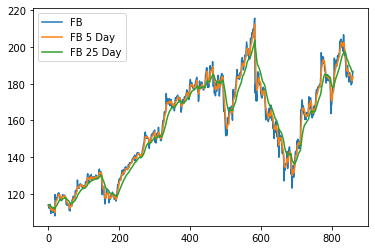

In [241]:
movAvg = df.y.ewm(span=5, adjust=False).mean()

movAvg2 = df.y.ewm(span=25, adjust=False).mean()

plt.plot(df.ds, df.y, label='FB')

plt.plot(df.ds, movAvg, label='FB 5 Day')

plt.plot(df.ds, movAvg2, label='FB 25 Day')

plt.legend(loc='upper left')

plt.show()

We can see that using this signal we could have predicted the price trend of FB. When short-term crosses above long-term we get a buy signal. When short-term passes below the longer-term we get a sell signal.

### Linear Regression of Simple Moving Average

In [217]:
movAverage= rolAvg
movAverage.shape

(861,)

In [218]:
# Sample for X,Y
T = 861

#mu = (facebook['Open '].mean(),facebook['Open '].mean(),facebook['Open '].mean()) 
#cov = [[1,0.75,-0.35],[0.75,1,0.9],[-0.35,0.9,1]]
#F = np.random.multivariate_normal(mu,cov,T)
#Sample for Y,X
X = movAvg
X = np.column_stack([np.ones((T,1)),X])
#X=pd.DataFrame(movAverage[4:])
#print(X)

N = X.shape
#beta = np.array([0.56,2.53,2.05,1.78])
#beta.shape=(N[1],1)
#Y =X@beta+np.random.normal(0,1,(T,1))
Y=facebook['Open'].values
print(Y.shape)
invXX = np.linalg.inv(X.transpose()@X)
beta_hat = invXX@X.transpose()@Y
y_hat = X@beta_hat
residuals = Y-y_hat
sigma2 = (1/T)*residuals.transpose()@residuals

sigma = np.sqrt(sigma2)

#variance - covariance of beta_hat
varcov_beta_hat = (sigma2)*invXX
std_beta_hat = np.sqrt(T*np.diag(varcov_beta_hat))

R_square = 1-(residuals.transpose()@residuals)/(T*np.var(Y))

adj_R_square = 1-(1-R_square)*(T-1)/(T - N[1])

#Testing Coefficents:beta_i
#Null Hypotesis

t_stat = (beta_hat.transpose()-0)/std_beta_hat
p_val = 1-ss.norm.cdf(t_stat)

#Test of joint significance
F_stat= (beta_hat.transpose()@np.linalg.inv(varcov_beta_hat)@beta_hat/N[1])/(residuals.transpose()@residuals/(T-N[1]))
p_val_F= 1 - ss.f.cdf(F_stat,N[1]-1, T-N[1])




(861,)


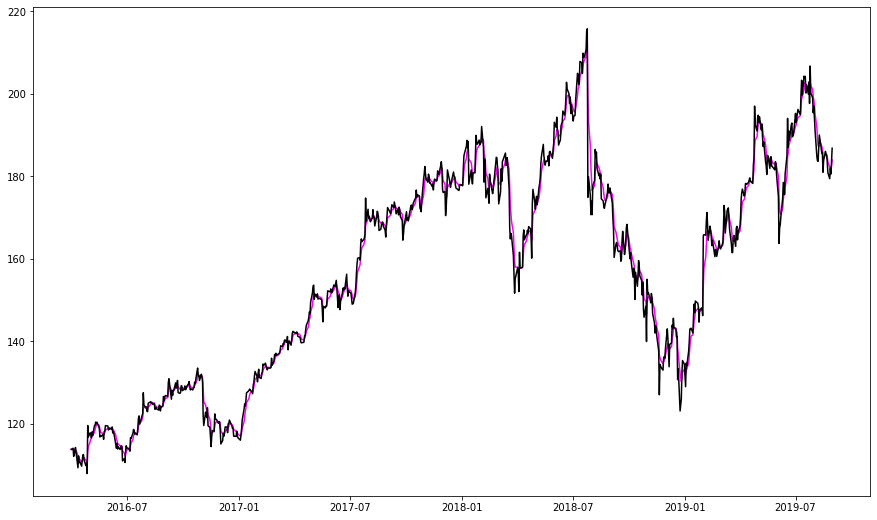

In [219]:
plt.plot(facebook['Date'],y_hat,color='magenta')
plt.plot(facebook['Date'],Y, color='black')
plt.show()

In [220]:
rmse = np.sqrt(np.mean((y_hat-Y)**2))
print(rmse)

2.5522796703913553


### Linear Regression of Exponential Moving Average

In [221]:
movAverage1= (movAvg)
movAverage1.shape

(861,)

In [222]:
# Sample for X,Y
T = 861
#mu = (facebook['Open '].mean(),facebook['Open '].mean(),facebook['Open '].mean()) 
#cov = [[1,0.75,-0.35],[0.75,1,0.9],[-0.35,0.9,1]]
#F = np.random.multivariate_normal(mu,cov,T)
#Sample for Y,X
X=movAverage1
X = np.column_stack([np.ones((T,1)),X])

N = X.shape
#beta = np.array([0.56,2.53,2.05,1.78])
#beta.shape=(N[1],1)
#Y =X@beta+np.random.normal(0,1,(T,1))
Y=facebook['Open'].values
print(X)
invXX = np.linalg.inv(X.transpose()@X)
beta_hat = invXX@X.transpose()@Y
y_hat = X@beta_hat
residuals = Y-y_hat
sigma2 = (1/T)*residuals.transpose()@residuals

sigma = np.sqrt(sigma2)

#variance - covariance of beta_hat
varcov_beta_hat = (sigma2)*invXX
std_beta_hat = np.sqrt(T*np.diag(varcov_beta_hat))

R_square = 1-(residuals.transpose()@residuals)/(T*np.var(Y))

adj_R_square = 1-(1-R_square)*(T-1)/(T - N[1])

#Testing Coefficents:beta_i
#Null Hypotesis

t_stat = (beta_hat.transpose()-0)/std_beta_hat
p_val = 1-ss.norm.cdf(t_stat)

#Test of joint significance
F_stat= (beta_hat.transpose()@np.linalg.inv(varcov_beta_hat)@beta_hat/N[1])/(residuals.transpose()@residuals/(T-N[1]))
p_val_F= 1 - ss.f.cdf(F_stat,N[1]-1, T-N[1])

[[  1.         113.75      ]
 [  1.         113.85666656]
 [  1.         113.27444458]
 ...
 [  1.         181.49212472]
 [  1.         182.2514179 ]
 [  1.         183.76094486]]


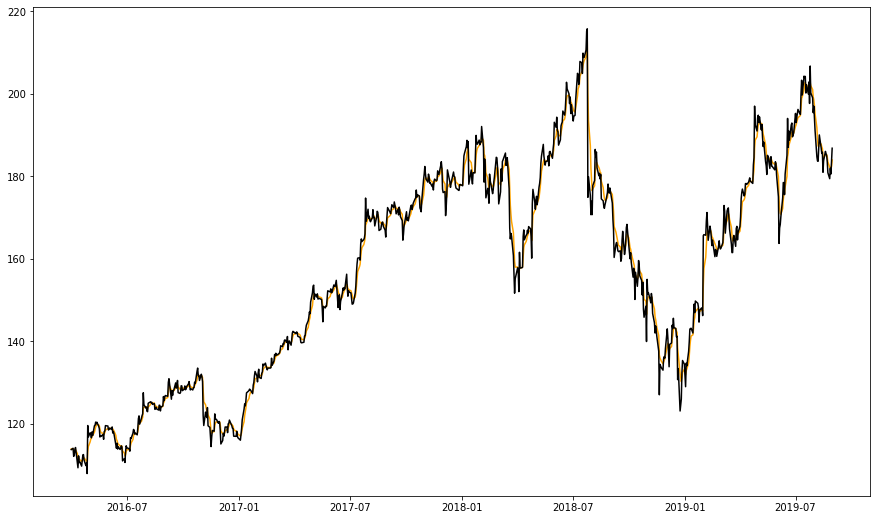

In [223]:
plt.plot(facebook['Date'],y_hat,color='orange')
plt.plot(facebook['Date'],Y, color='black')
plt.show()

In [224]:
rmse = np.sqrt(np.mean((y_hat-Y)**2))
print(rmse)

2.5522796703913553


## Autoregression

In [227]:
facebook['y_hat'] = y_hat

In [228]:
facebook.head()

,Date,High,Low,Open,Close,Volume,Adj Close,y_hat
0,2016-04-01,116.169998,113.349998,113.750000,116.059998,24760500,116.059998,113.890612
1,2016-04-04,114.550003,111.610001,114.070000,112.550003,48487900,112.550003,113.997333
2,2016-04-05,113.320000,111.900002,112.110001,112.220001,22962400,112.220001,113.414812
3,2016-04-06,113.809998,112.419998,112.470001,113.709999,20814600,113.709999,113.146527
4,2016-04-07,114.889999,113.070000,113.790001,113.639999,20714500,113.639999,113.407896


In [ ]:
#facebook = facebook.set_index(pd.DatetimeIndex(facebook['Date']))

In [ ]:
#facebook.head()

In [229]:
from pandas import Series
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
values = DataFrame(facebook['y_hat'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't']
result = dataframe.corr()
print(result)

          t-1         t
t-1  1.000000  0.998806
t    0.998806  1.000000


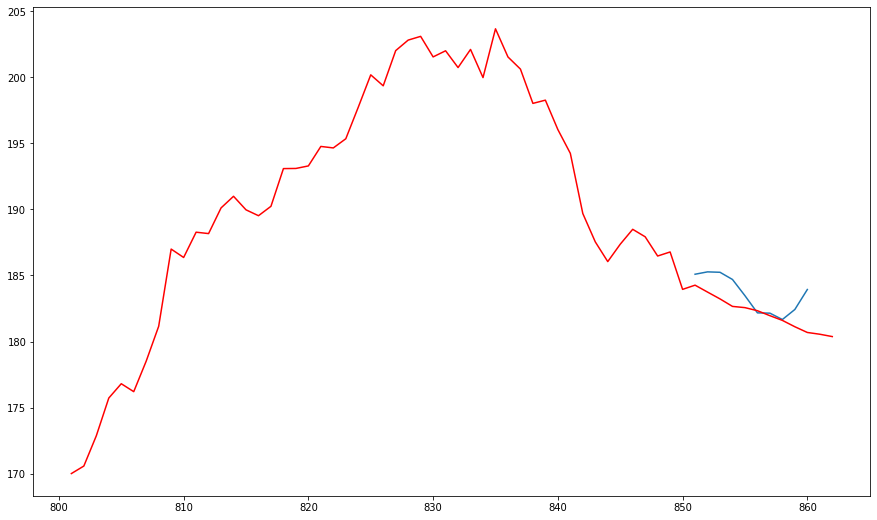

In [233]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR


# split dataset
X = facebook['y_hat']
#def AR(X):
train, test = X[1:len(X)-10], X[len(X)-10:]
# train autoregression
model = AR(train)
model_fit = model.fit()
#print('Lag: %s' % model_fit.k_ar)
#print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=800, end=861, dynamic=False)
#print(len(predictions))
#rmseCalc()
#return predictions
# error = mean_squared_error(test, predictions)
# print('Test MSE: %.3f' % error)
# plot results
#X = facebook['y_hat']
#predictions = AR(X)
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [234]:
model_fit.predict(600,610)

601    177.051683
602    175.957259
603    174.701870
604    173.659207
605    173.800723
606    173.809810
607    175.248558
608    176.784753
609    176.678906
610    176.276015
611    176.605957
dtype: float64

## CAPM

Beta, alpha, r_squared, volatility, momentum:
1.226229612230391 0.025581471551512983 0.2900380609000528 0.2640902322803233 0.05436074069773733


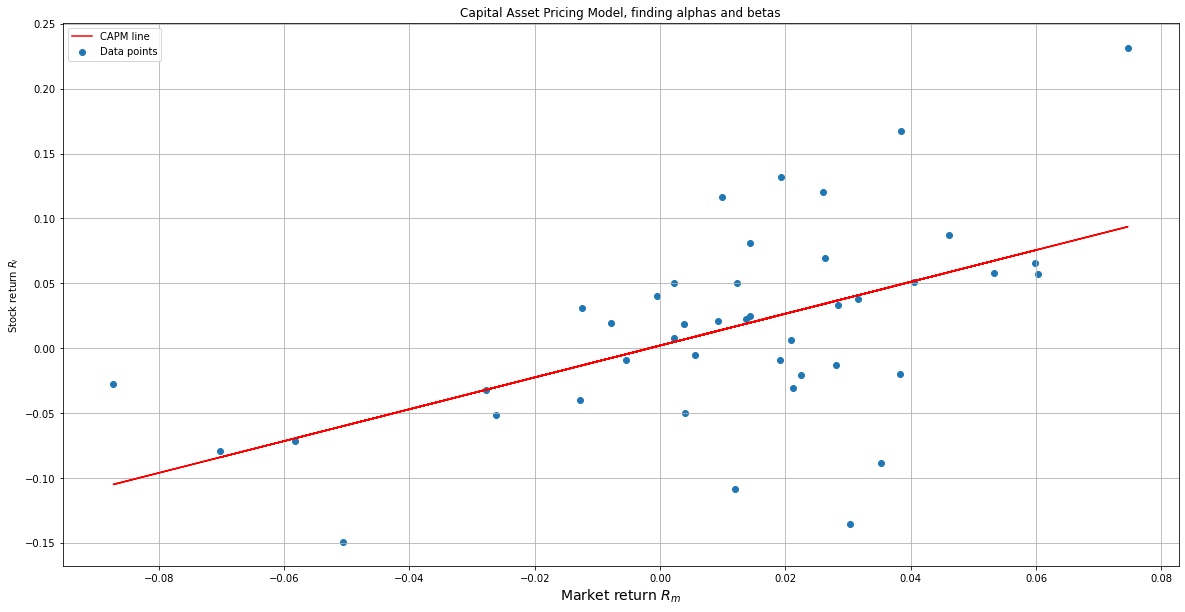

In [235]:
import pandas_datareader as pdr
from pandas_datareader import data, wb
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def capm(start_date, end_date, ticker1, ticker2):
    df = pdr.get_data_yahoo(ticker1, start_date, end_date)
    dfb = pdr.get_data_yahoo(ticker2, start_date, end_date)


    rts = df.resample('M').last()
    rbts = dfb.resample('M').last()
    dfsm = pd.DataFrame({'s_open' : rts['Open'], 'b_open' : rbts['Open']}, index=rts.index)


    dfsm[['s_returns', 'b_returns']] = dfsm[['s_open','b_open']]/dfsm[['s_open','b_open']].shift(1) -1
    dfsm = dfsm.dropna()

    covmat = np.cov(dfsm["s_returns"], dfsm["b_returns"])


    beta = covmat[0,1]/covmat[1,1]
    alpha = np.mean(dfsm["s_returns"])-beta*np.mean(dfsm["b_returns"])


    y = beta * dfsm["b_returns"] + alpha
    SS_res = np.sum(np.power(y - dfsm["s_returns"],2))
    SS_tot = covmat[0,0]*(len(dfsm) - 1) # SS_tot is sample_variance*(n-1)

    r_squared = 1.0 - SS_res/SS_tot
    volatility = np.sqrt(covmat[0,0])
    momentum = np.prod(1+dfsm["s_returns"].tail(12).values) - 1.0


    prd = 12.0 
    alpha = alpha*prd
    volatility = volatility*np.sqrt(prd)

    print ("Beta, alpha, r_squared, volatility, momentum:")
    print (beta, alpha, r_squared, volatility, momentum)

    %matplotlib inline
    fig,ax = plt.subplots(1,figsize=(20,10))
    ax.scatter(dfsm["b_returns"], dfsm['s_returns'], label="Data points")
    beta,alpha = np.polyfit(dfsm["b_returns"], dfsm['s_returns'], deg=1)
    ax.plot(dfsm["b_returns"], beta*dfsm["b_returns"] + alpha, color='red', label="CAPM line")

    
    plt.title('Capital Asset Pricing Model, finding alphas and betas')
    plt.xlabel('Market return $R_m$', fontsize=14)
    plt.ylabel('Stock return $R_i$')

    plt.legend()
    plt.grid(True)
    plt.show()
    return beta, y


beta, y = capm('2016-01-04', '2019-08-30','FB', '^GSPC')

### SVM

In [237]:
X = facebook[['Open']]
Y = facebook[['Open']].values

In [238]:
from sklearn.svm import SVR  

In [239]:
svr_model = SVR(kernel='rbf', gamma=0.0005)
result = svr_model.fit(X, Y)
 
y_hat = result.predict(X)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


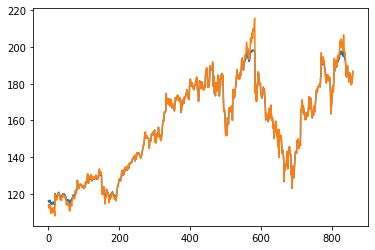

In [240]:
plt.plot(y_hat)
plt.plot(Y)

## Professionalism
50% Minghao Ru %50 Tong Yang


## Licensing
Copyright <2020> Minghao Ru, Tong Yang

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.